**Underfitting** occurs when your model cannot obtain sufficiently low loss on the training set. In this case, your model fails to learn the underlying patterns in your training data. On the other end of the spectrum, we have **overfitting** where your network models the training data too well and fails to generalize to your validation data.

Therefore, our goal when training a machine learning model is to:
1.  Reduce the training loss as much as possible.
2.  While ensuring the gap between the training and testing loss is reasonably small.

To combat overfitting, in general there are two techniques:
1. Reduce the complexity of the model
2. Apply regularization - highly prefered solution

**Sometimes, overfitting is an invitability. What we need is to control the 'generalization gap'**. At some point learning and validation loss will start diverging and we need to try and keep the gap under control. If we start seeing a rise in validation loss, we are stronly overfitting.

In [16]:
# import the necessary packages
from ndl.callbacks import TrainingMonitor
from sklearn.preprocessing import LabelBinarizer
from ndl.nn.conv import MiniVGGNet
from keras.optimizers import SGD
from keras.datasets import cifar10
import os

In [17]:
# show information on the process ID
print("[INFO process ID: {}".format(os.getpid()))
output = 'output'

[INFO process ID: 8712


In [18]:
# load the training and testing data, then scale it into the
# range [0, 1]
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

[INFO] loading CIFAR-10 data...


In [19]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [20]:
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [21]:
# initialize the SGD optimizer, but without any learning rate decay
print("[INFO] compiling model...")
opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


We're not including any decay on purpose to demonstrate monitoring and spot overfitting as it's happening.

In [22]:
# construct the set of callbacks
figPath = os.path.sep.join([output, "{}.png".format(os.getpid())])
jsonPath = os.path.sep.join([output, "{}.json".format(os.getpid())])
callbacks = [TrainingMonitor(figPath, jsonPath=jsonPath)]

## Once you start training, take a look at your output directory and you should see the training history and loss plots being stored.

- At epoch 5 we should still be underfitting
- At epoch 10 we see the first signs of overfitting, but perfectly normal
- At epoch 25 we see validation loss stagnating while training loss continues to go down. This is the start of overfitting.
- At epoch 50 we are clearly in trouble with validation loss going up. We should have stopped the experiment here and not waste more time. Re-assess parameters, try again...

If we let this go all over to epoch 100 we see our validation loss continuing to rise.

**Create the output directory before continuing**

As the training progress check out the plots to see these effects happening

In [23]:
# train the network
print("[INFO] training network...")
model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=50, callbacks=callbacks, verbose=1)

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.6446 - acc: 0.4542 - val_loss: 1.6057 - val_acc: 0.4619
Epoch 2/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.1433 - acc: 0.6100 - val_loss: 0.9157 - val_acc: 0.6742
Epoch 3/50
50000/50000 [==============================] - 12s 235us/step - loss: 0.9637 - acc: 0.6666 - val_loss: 0.8169 - val_acc: 0.7205
Epoch 4/50
50000/50000 [==============================] - 12s 235us/step - loss: 0.8629 - acc: 0.7015 - val_loss: 0.8920 - val_acc: 0.6904
Epoch 5/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.7826 - acc: 0.7257 - val_loss: 0.7315 - val_acc: 0.7482
Epoch 6/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.7256 - acc: 0.7463 - val_loss: 0.7095 - val_acc: 0.7539
Epoch 7/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.6713 -

<img src='27.png'/><img src='50.png' /><img src='100.png' />

This way we can monitor the training and not wait for the end to realize we are overfitting madly. We should have probably stopped this around the early 20s.

### Can we store intermediate values (checkpoint)?
Ofc we can! Keras provides the ModelCheckpoint callback exactly for this purpose

In [24]:
# initialize the SGD optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01, decay = 0.01 / 40, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [28]:
from keras.callbacks import ModelCheckpoint

# construct the callback to save only the *best* model to disk
# based on the validation loss
weights_dir = 'test_best'

# if we want to save every time there is an improvement - creates multiple files
fname = os.path.sep.join([weights_dir, "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])

# if we want to save the best model and overwrite once there is an improvement
#fname = weights_dir + '/cifar10_best_weights.hdf5'

checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [checkpoint]

Once we start training we should check our weights_dir where files should be appearing (multiple or one depending on the chosen method). We can also choose to monitor val_acc with mode="max" or even monitor train loss or train acc.

In [29]:
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=40, callbacks=callbacks, verbose=2)

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
 - 11s - loss: 1.1581 - acc: 0.5933 - val_loss: 0.9758 - val_acc: 0.6503

Epoch 00001: val_loss improved from inf to 0.97583, saving model to test_best\weights-001-0.9758.hdf5
Epoch 2/40
 - 11s - loss: 0.9681 - acc: 0.6597 - val_loss: 0.8115 - val_acc: 0.7174

Epoch 00002: val_loss improved from 0.97583 to 0.81149, saving model to test_best\weights-002-0.8115.hdf5
Epoch 3/40
 - 11s - loss: 0.8638 - acc: 0.6977 - val_loss: 0.7624 - val_acc: 0.7380

Epoch 00003: val_loss improved from 0.81149 to 0.76245, saving model to test_best\weights-003-0.7624.hdf5
Epoch 4/40
 - 11s - loss: 0.7838 - acc: 0.7242 - val_loss: 0.7322 - val_acc: 0.7483

Epoch 00004: val_loss improved from 0.76245 to 0.73219, saving model to test_best\weights-004-0.7322.hdf5
Epoch 5/40
 - 11s - loss: 0.7355 - acc: 0.7412 - val_loss: 0.6767 - val_acc: 0.7617

Epoch 00005: val_loss improved from 0.73219 to 0.67672, saving model to test_b

**As expected, the last saved model occurred shorty after epoch 20 (25 in this specific case)**
Results will vary due to different initialization values. They will also differ from the previous run because we are applying learning rate decay on this model.

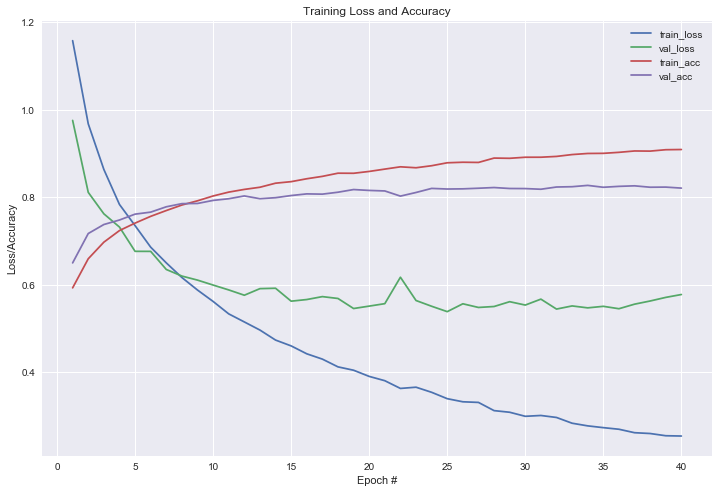

In [31]:
from ndl.utils.plot import plotKerasReport
plotKerasReport(H, 40)